In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model and reflect the tables
Base = automap_base()
Base.prepare(engine, reflect=True)


C:\Users\lavyh\AppData\Local\Temp\ipykernel_37756\1083889859.py:3: SADeprecationWarning: The AutomapBase.prepare.reflect parameter is deprecated and will be removed in a future release.  Reflection is enabled when AutomapBase.prepare.autoload_with is passed.
  Base.prepare(engine, reflect=True)


In [7]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [11]:
# Query the first row from the Measurement table
first_row = session.query(Measurement).first()
first_row.__dict__


{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x1eba7b61490>,
 'prcp': 0.08,
 'station': 'USC00519397',
 'tobs': 65.0,
 'id': 1,
 'date': '2010-01-01'}

In [12]:
# Count rows in Measurement table
measurement_count = session.query(func.count(Measurement.id)).scalar()
print(f"Measurement Table Rows: {measurement_count}")

# Count rows in Station table
station_count = session.query(func.count(Station.id)).scalar()
print(f"Station Table Rows: {station_count}")


Measurement Table Rows: 19550
Station Table Rows: 9


In [13]:
# Find the most recent date in the data set.
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")


one_year_ago = latest_date - dt.timedelta(days=365)

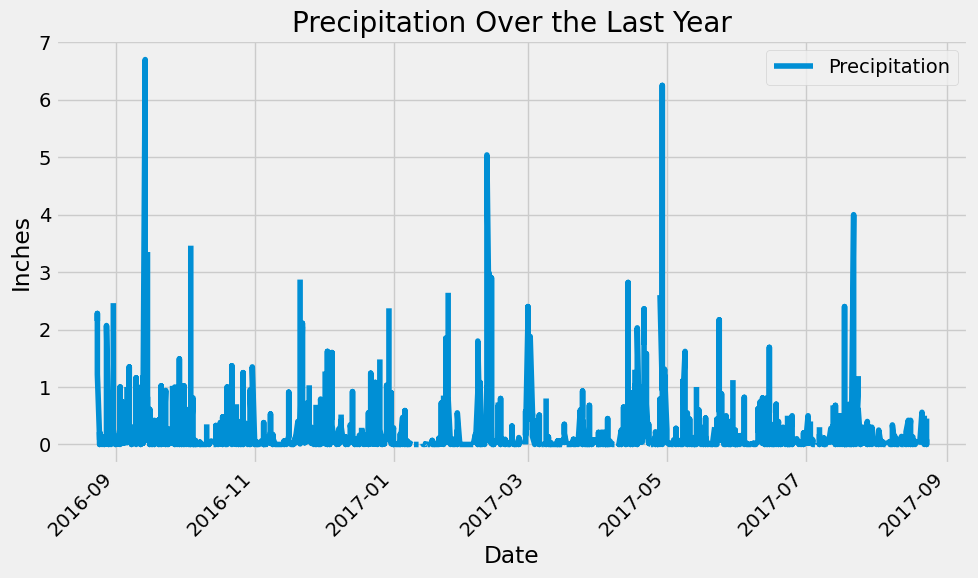

In [14]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. # Calculate the date one year from the last date in data set.

# Query precipitation data for the last year
precipitation_data = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= one_year_ago).all()

# Save the query results as a Pandas DataFrame with appropriate column names
precipitation_df = pd.DataFrame(precipitation_data, columns=["Date", "Precipitation"])

# Sort the DataFrame by date
precipitation_df["Date"] = pd.to_datetime(precipitation_df["Date"])  # Convert dates to datetime objects
precipitation_df.sort_values("Date", inplace=True)

# Plot the precipitation data using Pandas
precipitation_df.set_index("Date", inplace=True)
precipitation_df.plot(figsize=(10, 6), legend=True, title="Precipitation Over the Last Year")
plt.ylabel("Inches")
plt.xlabel("Date")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
summary_statistics = precipitation_df["Precipitation"].describe()

# Print the summary statistics
summary_statistics

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

# Exploratory Station Analysis

In [17]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(Station.station)).scalar()

print(f"Total number of stations: {total_stations}")

Total number of stations: 9


In [18]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
most_active_stations = (
    session.query(Measurement.station, func.count(Measurement.station))
    .group_by(Measurement.station)
    .order_by(func.count(Measurement.station).desc())
    .all()
)

# List the stations and their counts in descending order.
print("Most Active Stations (Station ID and Counts):")
for station, count in most_active_stations:
    print(f"Station: {station}, Count: {count}")

Most Active Stations (Station ID and Counts):
Station: USC00519281, Count: 2772
Station: USC00519397, Count: 2724
Station: USC00513117, Count: 2709
Station: USC00519523, Count: 2669
Station: USC00516128, Count: 2612
Station: USC00514830, Count: 2202
Station: USC00511918, Count: 1979
Station: USC00517948, Count: 1372
Station: USC00518838, Count: 511


In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
# Identify the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]  # The station with the highest count

# Query to calculate the lowest, highest, and average temperature for the most active station
temperature_summary = (
    session.query(
        func.min(Measurement.tobs),
        func.max(Measurement.tobs),
        func.avg(Measurement.tobs)
    )
    .filter(Measurement.station == most_active_station_id)
    .all()
)

# Extract the results
min_temp, max_temp, avg_temp = temperature_summary[0]

# Print the results
print(f"Temperature Summary for Station {most_active_station_id}:")
print(f"Lowest Temperature: {min_temp}°F")
print(f"Highest Temperature: {max_temp}°F")
print(f"Average Temperature: {avg_temp:.2f}°F")


Temperature Summary for Station USC00519281:
Lowest Temperature: 54.0°F
Highest Temperature: 85.0°F
Average Temperature: 71.66°F


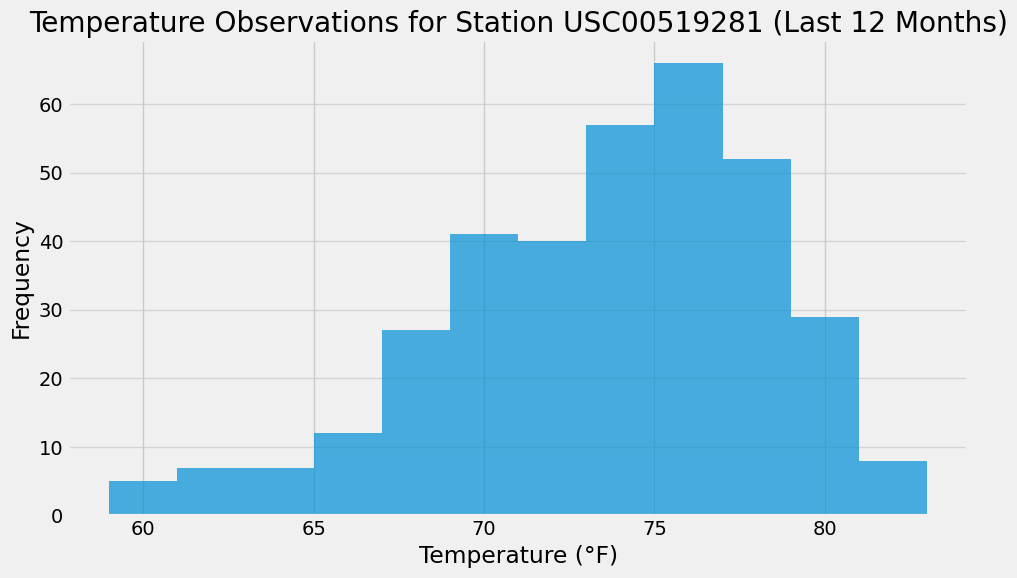

In [20]:
# Using the most active station id
# Identify the most active station ID from the previous query
most_active_station_id = most_active_stations[0][0]  # The station with the highest count

# Query the most recent date in the dataset
latest_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()[0]
latest_date = dt.datetime.strptime(latest_date, "%Y-%m-%d")
one_year_ago = latest_date - dt.timedelta(days=365)

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
tobs_data = (
    session.query(Measurement.tobs)
    .filter(Measurement.station == most_active_station_id)
    .filter(Measurement.date >= one_year_ago)
    .all()
)

# Convert the results to a Pandas DataFrame
tobs_df = pd.DataFrame(tobs_data, columns=["Temperature"])

# Plot the results as a histogram
plt.figure(figsize=(10, 6))
tobs_df["Temperature"].plot.hist(bins=12, alpha=0.7)
plt.title(f"Temperature Observations for Station {most_active_station_id} (Last 12 Months)")
plt.xlabel("Temperature (°F)")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75)
plt.tight_layout()
plt.show()

# Close Session

In [22]:
# Close Session
session.close()